#### importing libraries

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.path as mpath
import matplotlib.cm as cm
import xarray as xr
import cartopy.crs as ccrs
from matplotlib import colors as mcolors
from matplotlib.colors import ListedColormap
import cartopy.feature as cfeature
import cartopy.mpl.gridliner as gridliner
import matplotlib.ticker as mticker
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore", message="All-NaN slice encountered")

#### opening obs data

In [2]:
start_time=time.time()
path='/Users/thomas/Documents/Data'
obs=xr.open_mfdataset(path+'/CIS/*.nc')
end_time=time.time()
elapsed_time = end_time - start_time
# Convert seconds to hours, minutes, seconds
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

Execution time:  0.0 hours, 7.0 minutes, 21.1581072807312 seconds


#### selecting domain from obs data

In [4]:
obs

<xarray.Dataset>
Dimensions:       (rlon: 562, rlat: 498, lev: 1, time: 1508)
Coordinates:
  * rlon          (rlon) float64 -28.05 -27.95 -27.85 ... 27.85 27.95 28.05
  * rlat          (rlat) float64 -24.85 -24.75 -24.65 ... 24.65 24.75 24.85
  * lev           (lev) float64 0.0
  * time          (time) datetime64[ns] 1990-01-01 1990-01-08 ... 2018-12-25
    lon           (rlat, rlon) float64 dask.array<chunksize=(498, 562), meta=np.ndarray>
    lat           (rlat, rlon) float64 dask.array<chunksize=(498, 562), meta=np.ndarray>
Data variables: (12/13)
    rotated_pole  (time) |S1 b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b'' b''
    CT            (time, rlat, rlon) float32 dask.array<chunksize=(1, 498, 562), meta=np.ndarray>
    CA            (time, rlat, rlon) float32 dask.array<chunksize=(1, 498, 562), meta=np.ndarray>
    SA            (time, rlat, rlon) float32 dask.array<chunksize=(1, 498, 562), meta=np.ndarray>
    FA            (time, rlat, rlon) float32 dask.array<chunksize=(1, 498, 562), meta=np.ndarray>
    CB            (time, rlat, rlon) float32 dask.array<chunksize=(1, 498, 562), meta=np.ndarray>
    ...            ...
    FB            (time, rlat, rlon) float32 dask.array<chunksize=(1, 498, 562), meta=np.ndarray>
    CC            (time, rlat, rlon) float32 dask.array<chunksize=(1, 498, 562), meta=np.ndarray>
    SC            (time, rlat, rlon) float32 dask.array<chunksize=(1, 498, 562), meta=np.ndarray>
    FC            (time, rlat, rlon) float32 dask.array<chunksize=(1, 498, 562), meta=np.ndarray>
    bathy         (time, rlat, rlon) float32 dask.array<chunksize=(1, 498, 562), meta=np.ndarray>
    area          (time, rlat, rlon) float32 dask.array<chunksize=(1, 498, 562), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.4
    contact:        Lynn.Pogson@ec.gc.ca
    comment:        1991-2020 sea ice atlas
    creation_date:  2021
    frequency:      weekly
    institution:    Canadian Ice Service
    institute_id:   CIS
    references:     https://www.canada.ca/en/environment-climate-change/servi...

In [10]:
obs.SB

<xarray.DataArray 'SB' (time: 1508, rlat: 498, rlon: 562)>
dask.array<concatenate, shape=(1508, 498, 562), dtype=float32, chunksize=(1, 498, 562), chunktype=numpy.ndarray>
Coordinates:
  * rlon     (rlon) float64 -28.05 -27.95 -27.85 -27.75 ... 27.85 27.95 28.05
  * rlat     (rlat) float64 -24.85 -24.75 -24.65 -24.55 ... 24.65 24.75 24.85
  * time     (time) datetime64[ns] 1990-01-01 1990-01-08 ... 2018-12-25
    lon      (rlat, rlon) float64 dask.array<chunksize=(498, 562), meta=np.ndarray>
    lat      (rlat, rlon) float64 dask.array<chunksize=(498, 562), meta=np.ndarray>
Attributes:
    units:          Code Figure
    long_name:      Stage of Development Code
    standard_name:  Ice Thickness Code
    grid_mapping:   rotated_pole
    level_desc:     Arbitrary Levels
    time_desc:      19900101000000
    grid_desc:      rotated_pole
    cell_methods:   time: point

In [3]:
# Define the Labrador coast boundaries - obs
lat_min, lat_max = 50, 61
lon_min, lon_max =-65, -55  #65W & 55W

# Create a mask for Labrador coast 
mask = ((obs.lat>= lat_min) & (obs.lat <= lat_max) & (obs.lon >= lon_min) & (obs.lon<= lon_max))
obs_region =obs.where(mask, drop=True)

#### opening model data 

In [4]:
path1='/Users/thomas/Documents/Data/esemble 1001-001'
model=xr.open_mfdataset(path1+'/*.nc')

#### selecting the domain from model data

In [5]:
# Define the Labrador coast boundaries - model
lat_min, lat_max = 50, 61
lonmin, lonmax =295, 305 #65W & 55W

# Create a mask for Labrador coast 
mask2 = ((model.TLAT >= lat_min) & (model.TLAT <= lat_max) & (model.TLON >= lonmin) & (model.TLON <= lonmax))
model_region =model.where(mask2, drop=True)

#### selecting the SIC and area for both data

In [6]:
#obs
obs_CT=obs_region.CT
obs_area=obs_region.area

#model
model_CT=model_region.aice
model_area=model_region.tarea

#### converting obs code figure to actual values

In [7]:
#converting code figure to actual values
listnum = [-9.0, 1.0, 2.0, 10.0, 20.0, 30.0, 40.0, 50.0, 55.0, 60.0, 70.0, 80.0, 90.0, 91.0, 92.0, 98.0]
replace = [np.nan, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9, 0.95, 1, 0]

for i in range(16):
    obs_CT=obs_CT.where(obs_CT != listnum[i], replace[i])

In [8]:
#obs_CT=obs_CT.where(obs_CT >= 0.15, 0)
#obs_CT.values
#aice_region=((aice_region.where(aice_region>=0.15))*tarea_region)/1e12

#### calculating the total sea ice extent

In [9]:
#finding the actual concentration of each grid
#obs_total=(((obs_CT.where(obs_CT >= 0.15))*obs_area).sum(['rlat','rlon']))/1e6
#model_total=(((model_CT.where(model_CT >= 0.15))*model_area).sum(['nj','ni']))/1e12

In [10]:
#finding the actual concentration of each grid
obs_total=(((obs_CT.where(obs_CT >= 0.15))*obs_area).sum(['rlat','rlon']))/1e6
model_total=(((model_CT.where(model_CT >= 0.15))*model_area).sum(['nj','ni']))/1e12

In [11]:
obs_total=obs_total.where(obs_total>0,0)
model_total=model_total.where(model_total>0,0)

#### Plots - yearly mean

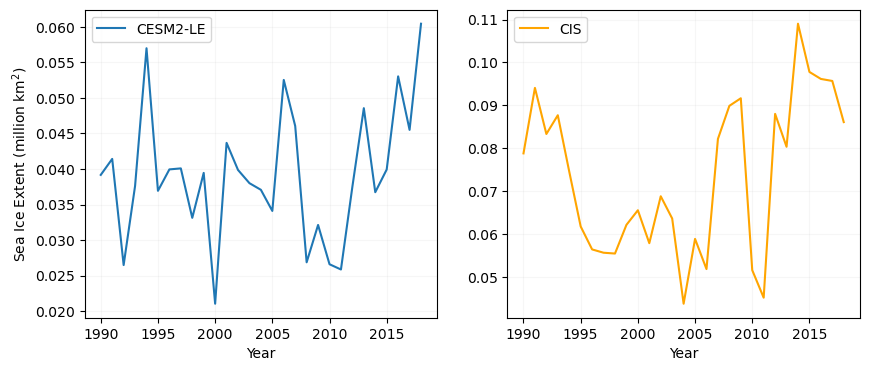

Execution time:  0.0 hours, 22.0 minutes, 19.74503803253174 seconds


In [27]:
#Plot of the obs and model from 1990 to 2018
start_time=time.time()

fig, ax=plt.subplots(1,2, figsize=(10,4))
model_yearly_mean = model_total.sel(time=slice('1990','2018')).groupby('time.year').mean('time')
obs_yearly_mean = obs_total.groupby('time.year').mean('time')

ax[0].plot(model_yearly_mean.year, model_yearly_mean, label='CESM2-LE')
ax[1].plot(obs_yearly_mean.year, obs_yearly_mean,  color='orange', label='CIS')
ax[0].set_xlabel('Year')
ax[1].set_xlabel('Year')
ax[0].set_ylabel('Sea Ice Extent (million km$^2$)')
#ax[1].set_ylabel('Total Sea Ice Extent (million km$^2$)')
ax[0].legend()
ax[1].legend()
ax[0].grid(alpha=0.1)
ax[1].grid(alpha=0.1)

plt.show()

end_time=time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

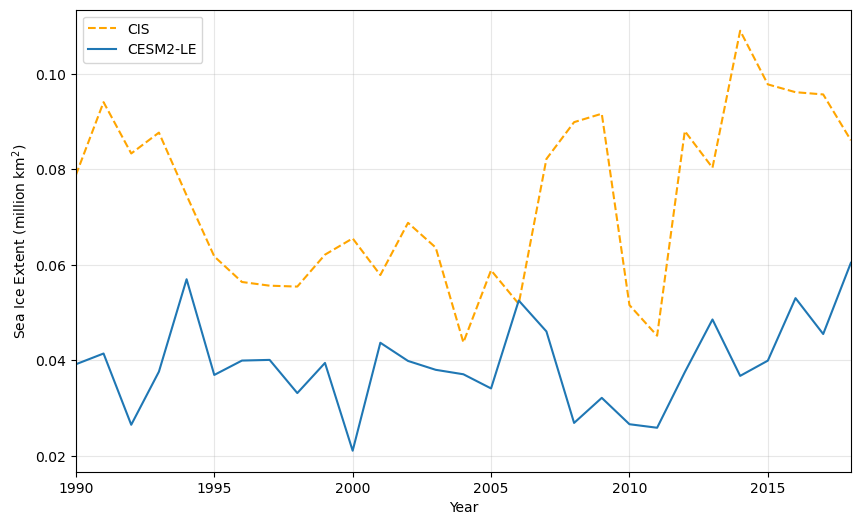

Execution time:  0.0 hours, 4.0 minutes, 35.29731583595276 seconds


In [64]:
#Plot of the obs and model from 1990 to 2018
start_time=time.time()
model_yearly_mean = model_total.sel(time=slice('1990','2018')).groupby('time.year').mean('time')
obs_yearly_mean = obs_total.groupby('time.year').mean('time')

fig, ax=plt.subplots( figsize=(10,6))

ax.plot(obs_yearly_mean.year, obs_yearly_mean,  color='orange', linestyle='--', label='CIS')
ax.plot(model_yearly_mean.year, model_yearly_mean, label='CESM2-LE')
#ax.set_title('Yearly mean Sea Ice Extent')
ax.set_xlabel('Year')
ax.set_ylabel('Sea Ice Extent (million km$^2$)')
ax.legend()
ax.grid(alpha=0.3)
plt.xlim(1990,2018)
plt.savefig(path+'/plots/'+'plot9.jpg',dpi=300, bbox_inches='tight') 
plt.show()


end_time=time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

#### Selecting september and march data from both obs and model

In [13]:
#slicing and resampling 
model_total_sel=model_total.sel(time=slice('1990','2018'))
obs_total_sel=obs_total.resample(time='1M').mean()

model_total_september=model_total_sel[8::12]
obs_total_september=obs_total_sel[8::12]
model_total_march=model_total_sel[2::12]
obs_total_march=obs_total_sel[2::12]

#### September and march Plot 

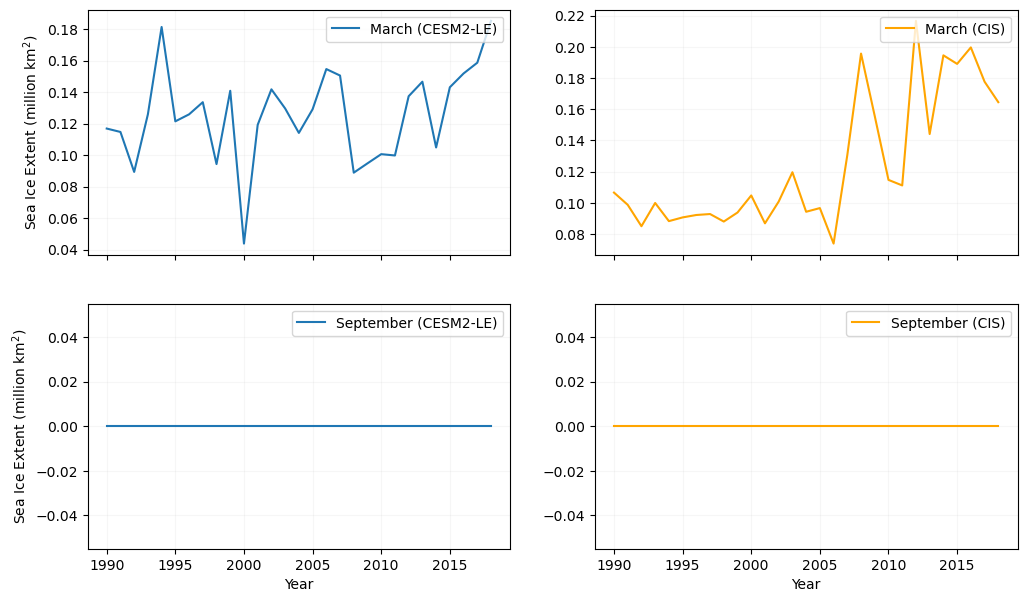

Execution time:  0.0 hours, 9.0 minutes, 30.06304621696472 seconds


In [38]:
#Plot of the obs and model from 1990 to 2018 for september and march
start_time=time.time()

fig, ax=plt.subplots(2,2, figsize=(12,7),sharex=True)
years=np.arange(1990,2019)
ax[0,0].plot(years, model_total_march, label='March (CESM2-LE)')
ax[0,1].plot(years, obs_total_march , color='orange',  label='March (CIS)')
ax[1,0].plot(years, model_total_september,  label='September (CESM2-LE)')
ax[1,1].plot(years, obs_total_september, color='orange', label='September (CIS)')

for i in range(2):
    for j in range(2):
        if (([i,j]==[1,0]) | ([i,j]==[1,1])):
            ax[i,j].set_xlabel('Year')
        if (([i,j]==[0,0]) | ([i,j]==[1,0])):
            ax[i,j].set_ylabel('Sea Ice Extent (million km$^2$)')
        ax[i,j].legend(loc='upper right')
        ax[i,j].grid(alpha=0.1)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.savefig('obs_model.jpg',dpi=300, bbox_inches='tight')       
plt.show()

end_time=time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

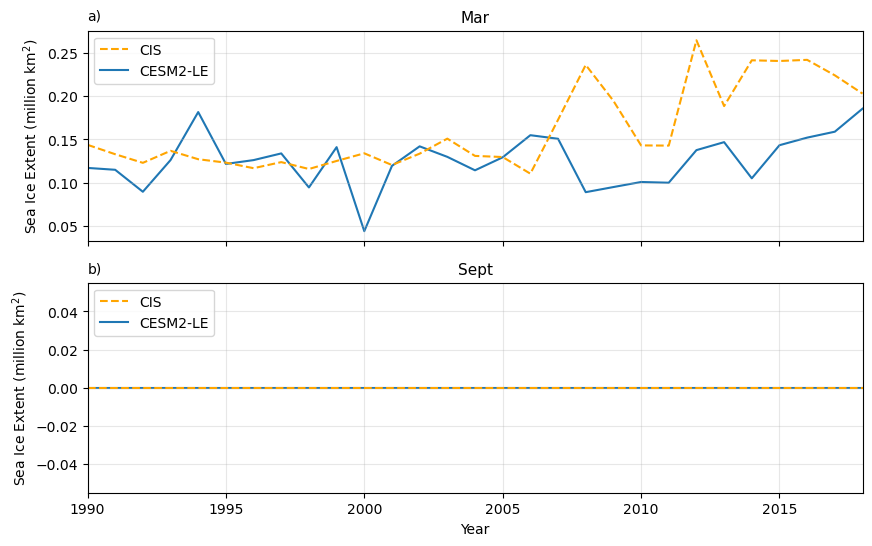

Execution time:  0.0 hours, 29.0 minutes, 43.18805408477783 seconds


In [22]:
import matplotlib.pyplot as plt
import numpy as np
import time

start_time = time.time()

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
years = np.arange(1990, 2019)

# First plot
ax[0].plot(years, obs_total_march, label='CIS', color='orange',linestyle='--', zorder=2)
ax[0].plot(years, model_total_march, label='CESM2-LE', zorder=1)
ax[0].set_ylabel('Sea Ice Extent (million km$^2$)')
ax[0].legend(loc='upper left')
ax[0].grid(alpha=0.3)

# Second plot
ax[1].plot(years, obs_total_september, label='CIS', color='orange', linestyle='--',zorder=2)
ax[1].plot(years, model_total_september, label='CESM2-LE',zorder=1)
ax[1].set_ylabel('Sea Ice Extent (million km$^2$)')
ax[1].legend(loc='upper left')
ax[1].grid(alpha=0.3)
ax[1].set_xlabel('Year')

ax[0].text(0, 1.05, 'a)',transform=ax[0].transAxes, fontsize=10)
ax[1].text(0, 1.05, 'b)',transform=ax[1].transAxes, fontsize=10)
ax[0].set_title('Mar', fontsize=11)
ax[1].set_title('Sept', fontsize=11)
plt.xlim(1990,2018)

'''
ax2 = ax[1].twinx()  # Create a twin Axes
ax[1].plot(years, model_total_september, label='September (CESM2-LE)')
ax2.plot(years, obs_total_september, label='September (CIS)', color='orange', linestyle='--')  # Plot on the twin Axes
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Sea Ice Extent (million km$^2$)')
ax2.set_ylabel('Sea Ice Extent (million km$^2$)', color='orange')  # Set the twin Axes' y-axis label

# Combine legends
lines1, labels1 = ax[1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax[1].legend(lines1 + lines2, labels1 + labels2, loc='lower left')

ax[1].grid(alpha=0.1)
'''
plt.savefig(path+'/plots/'+'plot10.jpg', dpi=300, bbox_inches='tight')
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")


#### Seasonally obs analysis

In [15]:
obs_1990_99 = obs_total_sel.sel(time=slice('1990', '1999'))
obs_2000_09 = obs_total_sel.sel(time=slice('2000', '2009'))
obs_2010_18 = obs_total_sel.sel(time=slice('2010', '2018'))


In [19]:
obs_1990_99_monthly = obs_1990_99.groupby('time.month').mean('time')
obs_2000_09_monthly = obs_2000_09.groupby('time.month').mean('time')
obs_2010_18_monthly = obs_2010_18.groupby('time.month').mean('time')

#### Seasonally model analysis

In [20]:
#Hist
model_1850_59 = model_total.sel(time=slice('1850-02-01', '1860-01-01'))
model_1860_69 = model_total.sel(time=slice('1860-02-01', '1870-01-01'))
model_1870_79 = model_total.sel(time=slice('1870-02-01', '1880-01-01'))
model_1880_89 = model_total.sel(time=slice('1880-02-01', '1890-01-01'))
model_1890_99 = model_total.sel(time=slice('1890-02-01', '1900-01-01'))
model_1900_09 = model_total.sel(time=slice('1900-02-01', '1910-01-01'))
model_1910_19 = model_total.sel(time=slice('1910-02-01', '1920-01-01'))
model_1920_29 = model_total.sel(time=slice('1920-02-01', '1930-01-01'))
model_1930_39 = model_total.sel(time=slice('1930-02-01', '1940-01-01'))
model_1940_49 = model_total.sel(time=slice('1940-02-01', '1950-01-01'))
model_1950_59 = model_total.sel(time=slice('1950-02-01', '1960-01-01'))
model_1960_69 = model_total.sel(time=slice('1960-02-01', '1970-01-01'))
model_1970_79 = model_total.sel(time=slice('1970-02-01', '1980-01-01'))
model_1980_89 = model_total.sel(time=slice('1980-02-01', '1990-01-01'))
model_1990_99 = model_total.sel(time=slice('1990-02-01', '2000-01-01'))
model_2000_09 = model_total.sel(time=slice('2000-02-01', '2010-01-01'))
model_2010_14 = model_total.sel(time=slice('2010-02-01', '2015-01-01'))
# Future
model_2015_24 = model_total.sel(time=slice('2015-02-01', '2025-01-01'))
model_2025_34 = model_total.sel(time=slice('2025-02-01', '2035-01-01'))
model_2035_44 = model_total.sel(time=slice('2035-02-01', '2045-01-01'))
model_2045_54 = model_total.sel(time=slice('2045-02-01', '2055-01-01'))
model_2055_64 = model_total.sel(time=slice('2055-02-01', '2065-01-01'))
model_2065_74 = model_total.sel(time=slice('2065-02-01', '2075-01-01'))
model_2075_84 = model_total.sel(time=slice('2075-02-01', '2085-01-01'))
model_2085_94 = model_total.sel(time=slice('2085-02-01', '2095-01-01'))
model_2095_100= model_total.sel(time=slice('2095-02-01', '2101-01-01'))

In [23]:
# Monthly mean hist
model_1850_59_monthly = model_1850_59.groupby('time.month').mean('time')
model_1860_69_monthly = model_1860_69.groupby('time.month').mean('time')
model_1870_79_monthly = model_1870_79.groupby('time.month').mean('time')
model_1880_89_monthly = model_1880_89.groupby('time.month').mean('time')
model_1890_99_monthly = model_1890_99.groupby('time.month').mean('time')
model_1900_09_monthly = model_1900_09.groupby('time.month').mean('time')
model_1910_19_monthly = model_1910_19.groupby('time.month').mean('time')
model_1920_29_monthly = model_1920_29.groupby('time.month').mean('time')
model_1930_39_monthly = model_1930_39.groupby('time.month').mean('time')
model_1940_49_monthly = model_1940_49.groupby('time.month').mean('time')
model_1950_59_monthly = model_1950_59.groupby('time.month').mean('time')
model_1960_69_monthly = model_1960_69.groupby('time.month').mean('time')
model_1970_79_monthly = model_1970_79.groupby('time.month').mean('time')
model_1980_89_monthly = model_1980_89.groupby('time.month').mean('time')
model_1990_99_monthly = model_1990_99.groupby('time.month').mean('time')
model_2000_09_monthly = model_2000_09.groupby('time.month').mean('time')
model_2010_14_monthly = model_2010_14.groupby('time.month').mean('time')

# Monthly mean future
model_2015_24_monthly = model_2015_24.groupby('time.month').mean('time')
model_2025_34_monthly = model_2025_34.groupby('time.month').mean('time')
model_2035_44_monthly = model_2035_44.groupby('time.month').mean('time')
model_2045_54_monthly = model_2045_54.groupby('time.month').mean('time')
model_2055_64_monthly = model_2055_64.groupby('time.month').mean('time')
model_2065_74_monthly = model_2065_74.groupby('time.month').mean('time')
model_2075_84_monthly = model_2075_84.groupby('time.month').mean('time')
model_2085_94_monthly = model_2085_94.groupby('time.month').mean('time')
model_2095_100_monthly= model_2095_100.groupby('time.month').mean('time')

#### seasonal plots

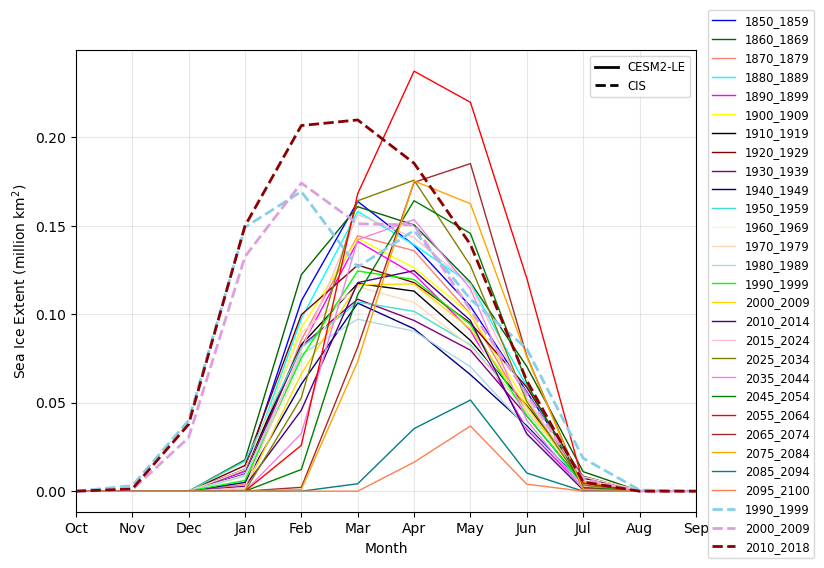

Execution time:  0.0 hours, 39.0 minutes, 53.357975006103516 seconds


In [30]:
# Set xticks to represent months from January to December
start_time = time.time()

fig,ax=plt.subplots(figsize=(8,6))
all_data = [model_1850_59_monthly, model_1860_69_monthly, model_1870_79_monthly, model_1880_89_monthly,
            model_1890_99_monthly, model_1900_09_monthly, model_1910_19_monthly, model_1920_29_monthly,
            model_1930_39_monthly, model_1940_49_monthly, model_1950_59_monthly, model_1960_69_monthly,
            model_1970_79_monthly, model_1980_89_monthly, model_1990_99_monthly, model_2000_09_monthly,
            model_2010_14_monthly, model_2015_24_monthly, model_2025_34_monthly, model_2035_44_monthly,
            model_2045_54_monthly, model_2055_64_monthly, model_2065_74_monthly, model_2075_84_monthly,
            model_2085_94_monthly, model_2095_100_monthly, obs_1990_99_monthly ,obs_2000_09_monthly ,
            obs_2010_18_monthly ]

    
labels = ['1850_1859', '1860_1869', '1870_1879', '1880_1889', '1890_1899', '1900_1909', '1910_1919',
          '1920_1929', '1930_1939', '1940_1949', '1950_1959', '1960_1969', '1970_1979', '1980_1989',
          '1990_1999', '2000_2009', '2010_2014', '2015_2024', '2025_2034', '2035_2044', '2045_2054',
          '2055_2064', '2065_2074', '2075_2084', '2085_2094', '2095_2100', '1990_1999', '2000_2009',
          '2010_2018']


colors = ['blue', 'darkgreen', 'salmon', 'cyan', 'magenta', 'yellow', 'black', 'maroon', 
          'purple',  'navy', 'turquoise','beige', 'peachpuff', 'lightblue', 'lime', 'gold',
          'indigo', 'pink', 'olive','violet', 'green', 'red',  'brown',
          'orange', 'teal', 'coral','SkyBlue', 'Plum', 'DarkRed']

for i in range(len(all_data)):
    if i<25:
        linestyle = '-' 
        linewidth=1# Default linestyle
    if i>25:
        linestyle = '--'
        linewidth=2# Change linestyle for specific labels

    ax.plot(np.append(all_data[i][9:],all_data[i][:9] ), color=colors[i], linestyle=linestyle,
            linewidth=linewidth, label=labels[i])
legend1 = ax.legend(loc='best',fontsize='small',bbox_to_anchor=(1.2, 1.1))

# Add the legend manually to the current Axes.
ax.add_artist(legend1)
namedatas=['CESM2-LE','CIS']
xdatas = [1, 1]
ydatas = [0.2, 0.15]
color = ['k', 'k']
linestyles = ['-', '--']
linewidths = [2, 2]

for x, y, name, c, ls, lw in zip(xdatas, ydatas, namedatas, color, linestyles, linewidths):
    ax.plot(x, y, color=c, linestyle=ls, linewidth=lw, label=name)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[len(all_data):], labels[len(all_data):], fontsize='small',loc='upper right')

plt.xticks(np.arange(0,12), ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun',
                             'Jul','Aug','Sep'])
plt.xlabel('Month')
plt.ylabel('Sea Ice Extent (million km$^2$)')
#plt.title('Seasonal Cycle of Sea ice Extent', fontweight='bold')
plt.plot(np.max(all_data[i].values))
#plt.legend(loc='best',fontsize='small')
plt.grid(alpha=0.3)
plt.xlim(0,11)
#plt.legend(loc='best',fontsize='small',bbox_to_anchor=(1.2, 1.05))
plt.savefig(path+'/plots/'+'plot1.jpg', dpi=300, bbox_inches='tight')
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

#### spatial plot

In [8]:
model_CT_sel=model_CT.sel(time=slice('1990','2018'))
obs_CT_sel=obs_CT.resample(time='1M').mean()

In [9]:
model_CT_sel=model_CT_sel.where(model_CT_sel>0,0)
#obs_CT_sel=obs_CT_sel.where(obs_CT_sel>0,0)

In [10]:
obs_CT_1990_99 = obs_CT_sel.sel(time=slice('1990', '1999'))
obs_CT_2000_09 = obs_CT_sel.sel(time=slice('2000', '2009'))
obs_CT_2010_18 = obs_CT_sel.sel(time=slice('2010', '2018'))

model_CT_1990_99 = model_CT_sel.sel(time=slice('1990', '1999'))
model_CT_2000_09 = model_CT_sel.sel(time=slice('2000', '2009'))
model_CT_2010_18 = model_CT_sel.sel(time=slice('2010', '2018'))

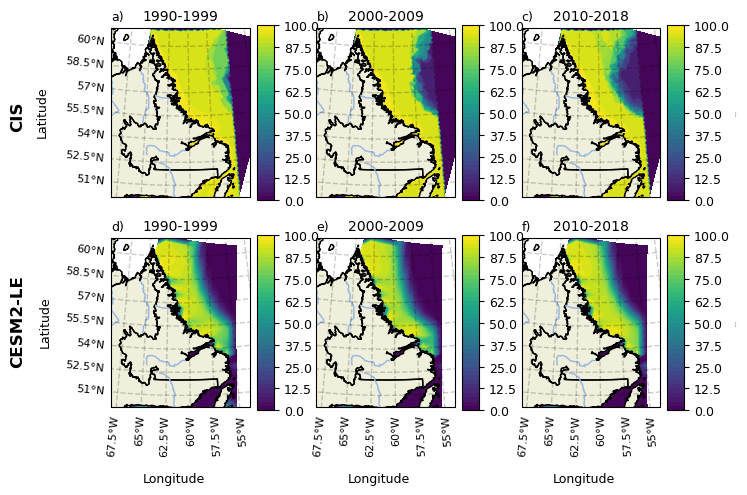

In [35]:
# Create a figure with two subplots
fig = plt.figure(figsize=(7.5,5))

selected_data=[obs_CT_1990_99,obs_CT_2000_09, obs_CT_2010_18, model_CT_1990_99, model_CT_2000_09,model_CT_2010_18]
titles=['1990-1999', '2000-2009','2010-2018','1990-1999', '2000-2009','2010-2018']
letter=['a)','b)','c)','d)','e)','f)']

x0, x1, y0, y1 = -68,-54,50,61

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i, v in enumerate(selected_data):
#for i in range(3):
    # Create a subplot with the PlateCarree projection
    ax = plt.subplot(2,3, i+1,projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                              central_latitude=c_lat,standard_parallels=(y0, y1)))
    ax.set_title(titles[i], fontsize=10)
    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.LAKES,  zorder=2)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.add_feature(cfeature.STATES,  zorder=2)
    ax.add_feature(cfeature.BORDERS,  zorder=2)
    #ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.RIVERS,  zorder=2)
    ax.set_extent([x0, x1, y0, y1])
    ax.text(0,1.05,letter[i], transform=ax.transAxes, fontsize=9)

    if i in [0,1,2]:
        contf=ax.contourf(selected_data[i].lon, selected_data[i].lat, selected_data[i].max('time')*100,
                          levels=45,transform=ccrs.PlateCarree())
    if i in [3,4,5]:
        contf=ax.contourf(selected_data[i].TLON, selected_data[i].TLAT, selected_data[i].max('time')*100,
                          levels=45,transform=ccrs.PlateCarree(), )
        
    gl = ax.gridlines(draw_labels=False, linewidth=1, color='black', alpha=0.2, linestyle='--',
                          transform=ccrs.PlateCarree())
    cbar=fig.colorbar(contf, ax=ax,aspect=10, pad=0.04,shrink=1 )
    cbar.ax.tick_params(labelsize=9)
    
    if i in [0,6]:
        gl.xlabels_bottom, gl.ylabels_left =  False, True
        gl.xlabels_top, gl.ylabels_right = False, False
        gl.xformatter = gridliner.LongitudeFormatter()
        gl.yformatter = gridliner.LatitudeFormatter()
        ax.text(-0.45, 0.51, 'latitude'.title(), va='bottom', ha='center', rotation='vertical',
                rotation_mode='anchor',fontsize=9, transform=ax.transAxes)
    
    if i in [2,5]:
        cbar.ax.set_ylabel('SIC (%)', fontsize=1)
        
    if i in [3]:
        ax.text(0.45, -0.46, 'longitude'.title(), va='bottom', ha='center', rotation='horizontal',
            rotation_mode='anchor',fontsize=9, transform=ax.transAxes)
        ax.text(-0.43, 0.51, 'latitude'.title(), va='bottom', ha='center', rotation='vertical',
                rotation_mode='anchor',fontsize=9, transform=ax.transAxes)
        gl.xlabels_bottom, gl.ylabels_left =  True, True
        gl.xlabels_top, gl.ylabels_right = False, False
        gl.xformatter = gridliner.LongitudeFormatter()
        gl.yformatter = gridliner.LatitudeFormatter()

        
    if i in [4,5]:
        ax.text(0.45, -0.46, 'longitude'.title(), va='bottom', ha='center', rotation='horizontal',
            rotation_mode='anchor',fontsize=9, transform=ax.transAxes)
        gl.xlabels_bottom, gl.ylabels_left =  True, False
        gl.xlabels_top, gl.ylabels_right = False, False
        gl.xformatter = gridliner.LongitudeFormatter()
        gl.yformatter = gridliner.LatitudeFormatter()

        
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
name=['CIS', 'CESM2-LE']
x=[0.01,0.01]
y=[0.7,0.29]
for i in range (2):
    fig.text(x[i],y[i], name[i], fontweight='bold',va='bottom', ha='center', rotation='vertical',
             rotation_mode='anchor',fontsize=12)
plt.subplots_adjust(wspace=0.15)
#plt.subplots_adjust(hspace=0.7)
plt.savefig(path+'/plots/'+'plot11.jpg',dpi=300, bbox_inches='tight')
plt.show()

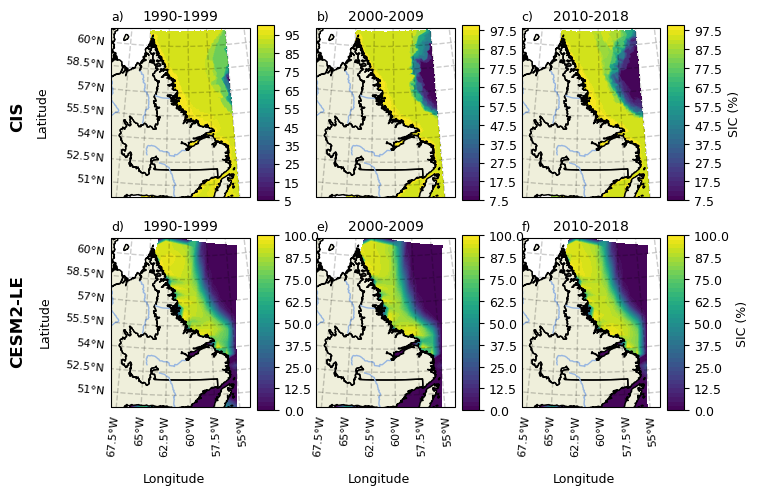

Execution time:  1.0 hours, 26.0 minutes, 35.248080015182495 seconds


In [11]:
# Create a figure with two subplots
start_time = time.time()

fig = plt.figure(figsize=(7.5,5))

selected_data=[obs_CT_1990_99,obs_CT_2000_09, obs_CT_2010_18, model_CT_1990_99, model_CT_2000_09,model_CT_2010_18]
titles=['1990-1999', '2000-2009','2010-2018','1990-1999', '2000-2009','2010-2018']
letter=['a)','b)','c)','d)','e)','f)']

x0, x1, y0, y1 = -68,-54,50,61

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i, v in enumerate(selected_data):
#for i in range(3):
    # Create a subplot with the PlateCarree projection
    ax = plt.subplot(2,3, i+1,projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                              central_latitude=c_lat,standard_parallels=(y0, y1)))
    ax.set_title(titles[i], fontsize=10)
    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.LAKES,  zorder=2)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.add_feature(cfeature.STATES,  zorder=2)
    ax.add_feature(cfeature.BORDERS,  zorder=2)
    #ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.RIVERS,  zorder=2)
    ax.set_extent([x0, x1, y0, y1])
    ax.text(0,1.05,letter[i], transform=ax.transAxes, fontsize=9)

    if i in [0,1,2]:
        contf=ax.contourf(selected_data[i].lon, selected_data[i].lat, selected_data[i].max('time')*100,
                          levels=45,transform=ccrs.PlateCarree())
    if i in [3,4,5]:
        contf=ax.contourf(selected_data[i].TLON, selected_data[i].TLAT, selected_data[i].max('time')*100,
                          levels=45,transform=ccrs.PlateCarree(), )
        
    gl = ax.gridlines(draw_labels=False, linewidth=1, color='black', alpha=0.2, linestyle='--',
                          transform=ccrs.PlateCarree())
    cbar=fig.colorbar(contf, ax=ax,aspect=10, pad=0.04,shrink=1 )
    cbar.ax.tick_params(labelsize=9)
    
    if i in [0,6]:
        gl.xlabels_bottom, gl.ylabels_left =  False, True
        gl.xlabels_top, gl.ylabels_right = False, False
        gl.xformatter = gridliner.LongitudeFormatter()
        gl.yformatter = gridliner.LatitudeFormatter()
        ax.text(-0.45, 0.51, 'latitude'.title(), va='bottom', ha='center', rotation='vertical',
                rotation_mode='anchor',fontsize=9, transform=ax.transAxes)
    
    if i in [2,5]:
        cbar.ax.set_ylabel('SIC (%)', fontsize=9)
        
    if i in [3]:
        ax.text(0.45, -0.46, 'longitude'.title(), va='bottom', ha='center', rotation='horizontal',
            rotation_mode='anchor',fontsize=9, transform=ax.transAxes)
        ax.text(-0.43, 0.51, 'latitude'.title(), va='bottom', ha='center', rotation='vertical',
                rotation_mode='anchor',fontsize=9, transform=ax.transAxes)
        gl.xlabels_bottom, gl.ylabels_left =  True, True
        gl.xlabels_top, gl.ylabels_right = False, False
        gl.xformatter = gridliner.LongitudeFormatter()
        gl.yformatter = gridliner.LatitudeFormatter()

        
    if i in [4,5]:
        ax.text(0.45, -0.46, 'longitude'.title(), va='bottom', ha='center', rotation='horizontal',
            rotation_mode='anchor',fontsize=9, transform=ax.transAxes)
        gl.xlabels_bottom, gl.ylabels_left =  True, False
        gl.xlabels_top, gl.ylabels_right = False, False
        gl.xformatter = gridliner.LongitudeFormatter()
        gl.yformatter = gridliner.LatitudeFormatter()

        
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
name=['CIS', 'CESM2-LE']
x=[0.01,0.01]
y=[0.7,0.29]
for i in range (2):
    fig.text(x[i],y[i], name[i], fontweight='bold',va='bottom', ha='center', rotation='vertical',
             rotation_mode='anchor',fontsize=12)
plt.subplots_adjust(wspace=0.2)
#plt.subplots_adjust(hspace=0.7)
plt.savefig(path+'/plots/'+'plot11a.jpg',dpi=300, bbox_inches='tight')
plt.show()


end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

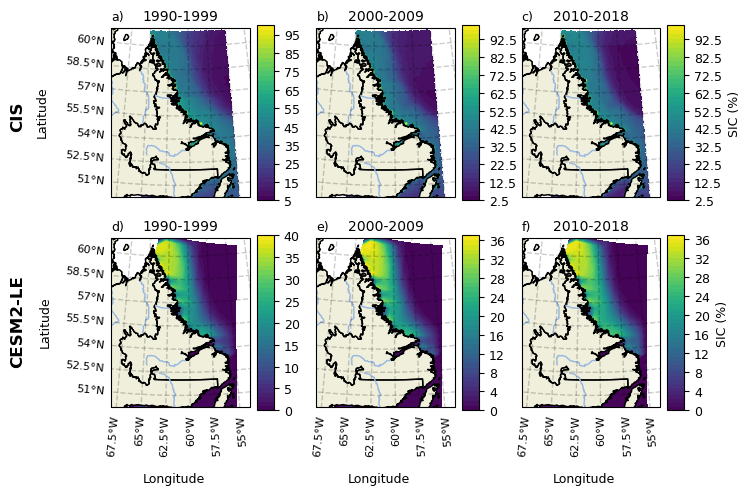

Execution time:  1.0 hours, 9.0 minutes, 44.8246431350708 seconds


In [13]:
# Create a figure with two subplots
start_time = time.time()

fig = plt.figure(figsize=(7.5,5))

selected_data=[obs_CT_1990_99,obs_CT_2000_09, obs_CT_2010_18, model_CT_1990_99, model_CT_2000_09,model_CT_2010_18]
titles=['1990-1999', '2000-2009','2010-2018','1990-1999', '2000-2009','2010-2018']
letter=['a)','b)','c)','d)','e)','f)']

x0, x1, y0, y1 = -68,-54,50,61

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i, v in enumerate(selected_data):
#for i in range(3):
    # Create a subplot with the PlateCarree projection
    ax = plt.subplot(2,3, i+1,projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                              central_latitude=c_lat,standard_parallels=(y0, y1)))
    ax.set_title(titles[i], fontsize=10)
    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.LAKES,  zorder=2)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.add_feature(cfeature.STATES,  zorder=2)
    ax.add_feature(cfeature.BORDERS,  zorder=2)
    #ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.RIVERS,  zorder=2)
    ax.set_extent([x0, x1, y0, y1])
    ax.text(0,1.05,letter[i], transform=ax.transAxes, fontsize=9)

    if i in [0,1,2]:
        contf=ax.contourf(selected_data[i].lon, selected_data[i].lat, selected_data[i].mean('time')*100,
                          levels=45,transform=ccrs.PlateCarree())
    if i in [3,4,5]:
        contf=ax.contourf(selected_data[i].TLON, selected_data[i].TLAT, selected_data[i].mean('time')*100,
                          levels=45,transform=ccrs.PlateCarree(), )
        
    gl = ax.gridlines(draw_labels=False, linewidth=1, color='black', alpha=0.2, linestyle='--',
                          transform=ccrs.PlateCarree())
    cbar=fig.colorbar(contf, ax=ax,aspect=10, pad=0.04,shrink=1 )
    cbar.ax.tick_params(labelsize=9)
    
    if i in [0,6]:
        gl.xlabels_bottom, gl.ylabels_left =  False, True
        gl.xlabels_top, gl.ylabels_right = False, False
        gl.xformatter = gridliner.LongitudeFormatter()
        gl.yformatter = gridliner.LatitudeFormatter()
        ax.text(-0.45, 0.51, 'latitude'.title(), va='bottom', ha='center', rotation='vertical',
                rotation_mode='anchor',fontsize=9, transform=ax.transAxes)
    
    if i in [2,5]:
        cbar.ax.set_ylabel('SIC (%)', fontsize=9)
        
    if i in [3]:
        ax.text(0.45, -0.46, 'longitude'.title(), va='bottom', ha='center', rotation='horizontal',
            rotation_mode='anchor',fontsize=9, transform=ax.transAxes)
        ax.text(-0.43, 0.51, 'latitude'.title(), va='bottom', ha='center', rotation='vertical',
                rotation_mode='anchor',fontsize=9, transform=ax.transAxes)
        gl.xlabels_bottom, gl.ylabels_left =  True, True
        gl.xlabels_top, gl.ylabels_right = False, False
        gl.xformatter = gridliner.LongitudeFormatter()
        gl.yformatter = gridliner.LatitudeFormatter()

        
    if i in [4,5]:
        ax.text(0.45, -0.46, 'longitude'.title(), va='bottom', ha='center', rotation='horizontal',
            rotation_mode='anchor',fontsize=9, transform=ax.transAxes)
        gl.xlabels_bottom, gl.ylabels_left =  True, False
        gl.xlabels_top, gl.ylabels_right = False, False
        gl.xformatter = gridliner.LongitudeFormatter()
        gl.yformatter = gridliner.LatitudeFormatter()

        
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
name=['CIS', 'CESM2-LE']
x=[0.01,0.01]
y=[0.7,0.29]
for i in range (2):
    fig.text(x[i],y[i], name[i], fontweight='bold',va='bottom', ha='center', rotation='vertical',
             rotation_mode='anchor',fontsize=12)
plt.subplots_adjust(wspace=0.2)
#plt.subplots_adjust(hspace=0.7)
plt.savefig(path+'/plots/'+'plot11b.jpg',dpi=300, bbox_inches='tight')
plt.show()


end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

In [ ]:
# Create a figure with two subplots
start_time = time.time()

fig = plt.figure(figsize=(7.5,5))
levels = np.linspace(0, 50, num=11) 
selected_data=[obs_CT_1990_99,obs_CT_2000_09, obs_CT_2010_18, model_CT_1990_99, model_CT_2000_09,model_CT_2010_18]
titles=['1990-1999', '2000-2009','2010-2018','1990-1999', '2000-2009','2010-2018']
letter=['a)','b)','c)','d)','e)','f)']

x0, x1, y0, y1 = -68,-54,50,61

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i, v in enumerate(selected_data):
#for i in range(3):
    # Create a subplot with the PlateCarree projection
    ax = plt.subplot(2,3, i+1,projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                              central_latitude=c_lat,standard_parallels=(y0, y1)))
    ax.set_title(titles[i], fontsize=10)
    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.LAKES,  zorder=2)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.add_feature(cfeature.STATES,  zorder=2)
    ax.add_feature(cfeature.BORDERS,  zorder=2)
    #ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.RIVERS,  zorder=2)
    ax.set_extent([x0, x1, y0, y1])
    ax.text(0,1.05,letter[i], transform=ax.transAxes, fontsize=9)

    if i in [0,1,2]:
        contf=ax.contourf(selected_data[i].lon, selected_data[i].lat,vmax=70,levels=levels,
                          selected_data[i].mean('time')*100,transform=ccrs.PlateCarree())
    if i in [3,4,5]:
        contf=ax.contourf(selected_data[i].TLON, selected_data[i].TLAT,vmax=70,levels=levels,
                          selected_data[i].mean('time')*100,transform=ccrs.PlateCarree())
        
    gl = ax.gridlines(draw_labels=False, linewidth=1, color='black', alpha=0.2, linestyle='--',
                          transform=ccrs.PlateCarree())
    cbar=fig.colorbar(contf, ax=ax,aspect=10, pad=0.04,shrink=1 )
    cbar.ax.tick_params(labelsize=9)
    
    if i in [0,6]:
        gl.xlabels_bottom, gl.ylabels_left =  False, True
        gl.xlabels_top, gl.ylabels_right = False, False
        gl.xformatter = gridliner.LongitudeFormatter()
        gl.yformatter = gridliner.LatitudeFormatter()
        ax.text(-0.45, 0.51, 'latitude'.title(), va='bottom', ha='center', rotation='vertical',
                rotation_mode='anchor',fontsize=9, transform=ax.transAxes)
    
    if i in [2,5]:
        cbar.ax.set_ylabel('SIC (%)', fontsize=9)
        
    if i in [3]:
        ax.text(0.45, -0.46, 'longitude'.title(), va='bottom', ha='center', rotation='horizontal',
            rotation_mode='anchor',fontsize=9, transform=ax.transAxes)
        ax.text(-0.43, 0.51, 'latitude'.title(), va='bottom', ha='center', rotation='vertical',
                rotation_mode='anchor',fontsize=9, transform=ax.transAxes)
        gl.xlabels_bottom, gl.ylabels_left =  True, True
        gl.xlabels_top, gl.ylabels_right = False, False
        gl.xformatter = gridliner.LongitudeFormatter()
        gl.yformatter = gridliner.LatitudeFormatter()

        
    if i in [4,5]:
        ax.text(0.45, -0.46, 'longitude'.title(), va='bottom', ha='center', rotation='horizontal',
            rotation_mode='anchor',fontsize=9, transform=ax.transAxes)
        gl.xlabels_bottom, gl.ylabels_left =  True, False
        gl.xlabels_top, gl.ylabels_right = False, False
        gl.xformatter = gridliner.LongitudeFormatter()
        gl.yformatter = gridliner.LatitudeFormatter()

        
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
name=['CIS', 'CESM2-LE']
x=[0.01,0.01]
y=[0.7,0.29]
for i in range (2):
    fig.text(x[i],y[i], name[i], fontweight='bold',va='bottom', ha='center', rotation='vertical',
             rotation_mode='anchor',fontsize=12)
plt.subplots_adjust(wspace=0.2)
#plt.subplots_adjust(hspace=0.7)
plt.savefig(path+'/plots/'+'plot11b.jpg',dpi=300, bbox_inches='tight')
plt.show()


end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

In [114]:
for i in selected_data1:
    print(np.nanmax(i.mean('time').values))

1.0
1.0
1.0
0.39098117
0.3692288
0.36029664


In [ ]:
list1=[0.1435757 , 0.13270953, 0.12275052, 0.13663583, 0.12691775,
       0.12296775, 0.11655349, 0.1235714 , 0.11562628, 0.12491794,
       0.13375503, 0.12021293, 0.133364  , 0.15071483, 0.13075939,
       0.1294479 , 0.11021987, 0.17248644, 0.23590264, 0.19441916,
       0.1428865 , 0.14265677, 0.26439434, 0.18833336, 0.24124293,
       0.24044889, 0.24176773, 0.22386736, 0.20277932]
list2=[0.11688087, 0.114714  , 0.08931906, 0.12594375, 0.18142769,
       0.12146794, 0.12590852, 0.13363494, 0.09429155, 0.14088333,
       0.04376626, 0.11923813, 0.14180598, 0.12964834, 0.11410614,
       0.12912364, 0.15468805, 0.15056747, 0.08883988, 0.09476177,
       0.10060393, 0.09976729, 0.13742602, 0.14665408, 0.10485141,
       0.14310928, 0.15188354, 0.15872757, 0.18532678]
years=np.arange(1990,2019)

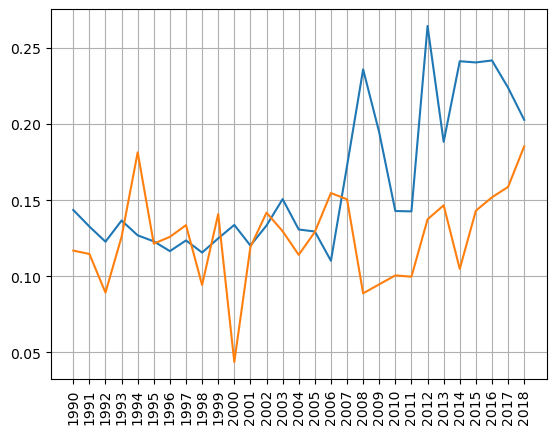

In [55]:
plt.plot(years,list1)
plt.plot(years,list2)
plt.xticks(years, rotation=90);
plt.grid()

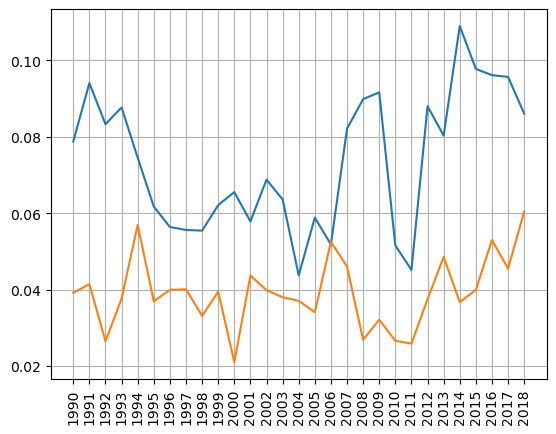

In [57]:
list1=[0.07879654, 0.09407539, 0.08332091, 0.0876954 , 0.07454611,
       0.0617567 , 0.05640008, 0.05562814, 0.05543805, 0.06212606,
       0.0655345 , 0.0578557 , 0.06879575, 0.06361438, 0.04373479,
       0.05885301, 0.05181444, 0.08217341, 0.08988374, 0.09165187,
       0.05155866, 0.04514456, 0.08801512, 0.0803365 , 0.10903774,
       0.09779406, 0.09616179, 0.09568982, 0.08609276]

list2=[0.03916775, 0.04141646, 0.02649111, 0.03761521, 0.0569758 ,
       0.0369279 , 0.03994   , 0.04008147, 0.03312868, 0.03944632,
       0.02105361, 0.04367094, 0.03986162, 0.03800331, 0.03706908,
       0.03409975, 0.05251725, 0.04604461, 0.02687682, 0.03212826,
       0.0266047 , 0.02586491, 0.03751191, 0.04854797, 0.03673308,
       0.0399269 , 0.0530187 , 0.04550003, 0.06042321]
plt.plot(years,list1)
plt.plot(years,list2)
plt.xticks(years, rotation=90);
plt.grid()

In [ ]:
model_yearly_mean = model_total.sel(time=slice('1990','2018')).groupby('time.year').mean('time')

In [ ]:
model_yearly_mean.values

array([0.03916775, 0.04141646, 0.02649111, 0.03761521, 0.0569758 ,
       0.0369279 , 0.03994   , 0.04008147, 0.03312868, 0.03944632,
       0.02105361, 0.04367094, 0.03986162, 0.03800331, 0.03706908,
       0.03409975, 0.05251725, 0.04604461, 0.02687682, 0.03212826,
       0.0266047 , 0.02586491, 0.03751191, 0.04854797, 0.03673308,
       0.0399269 , 0.0530187 , 0.04550003, 0.06042321], dtype=float32)

In [ ]:
w